<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/main/updatedLSTMVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-warning">
This is an exercise to be handed in on Peergrade
</div>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import pandas as pd
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
import copy

from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

## Torch


In [2]:
import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor
from functools import reduce
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

from torch import nn, optim
import torch.nn.functional as F


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features,dropout, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      dropout = dropout,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      dropout = dropout,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [5]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [6]:
class ReEncoder(nn.Module):

  def __init__(self, seq_len, n_features,dropout, embedding_dim=64):
    super(ReEncoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      dropout = dropout,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      dropout = dropout,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [7]:
import torch.nn as nn
from torch.nn.functional import softplus


class LSTMVAE(nn.Module):
    def __init__(self, latent_features, seq_len,n_features,dropout_rate,embedding_dim=64):
        super(LSTMVAE, self).__init__()
        
        self.latent_features = latent_features
        # We encode the data onto the latent space using two linear layers
        self.encoder = Encoder(seq_len, n_features,dropout_rate, embedding_dim)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc_mu = nn.Linear(128, latent_features)
        self.fc_log_var = nn.Linear(128, latent_features)
        self.fc2 = nn.Linear(latent_features, embedding_dim)

        self.decoder = Decoder(seq_len, embedding_dim, n_features)

        ### re encoder
        self.reencoder = ReEncoder(seq_len, n_features,dropout_rate, embedding_dim)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x): 
        outputs = {}
        
        x = self.encoder(x)

        hidden = self.fc1(x)
        # get `mu` and `log_var` from hidden
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        # latent to hidden 
        x = self.fc2(z)
        
        # Run through decoder
        x = self.decoder(x)
        
        x = x.unsqueeze(-1)

        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var

        #### re encoder
        x_bar = self.reencoder(x_hat)
        hidden_bar = self.fc1(x_bar)
        # get `mu` and `log_var` from hidden
        mu_bar = self.fc_mu(hidden_bar)
        log_var_bar = self.fc_log_var(hidden_bar)
        # get the latent vector through reparameterization
        z_bar = self.reparameterize(mu_bar, log_var_bar)
        outputs["z_bar"] = z_bar
        outputs["mu"] = mu_bar
        outputs["log_var"] = log_var_bar
        ### end of re encoder
        return outputs

In [8]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

# Loading the data

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
normal = pd.read_csv('/content/drive/My Drive/adml/normal_df.csv')
anomaly = pd.read_csv('/content/drive/My Drive/adml/anomaly_df.csv')


In [12]:
normal.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
0,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799774,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.233402,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
1,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.573868,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.444721,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
3,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.340341,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489

In [13]:
train_x, val_x = train_test_split(normal,test_size=0.15,random_state=RANDOM_SEED)
val_x, test_x = train_test_split(val_x,test_size=0.33, random_state=RANDOM_SEED)

In [14]:
train_dataset, seq_len, n_features = create_dataset(train_x)
val_dataset, _, _ = create_dataset(val_x)
test_normal_dataset, _, _ = create_dataset(test_x)
test_anomaly_dataset, _, _ = create_dataset(anomaly)

In [15]:
latent_features = 10
dropout_rate = 0.2

#seq_len = train_x.shape[1]
#n_features = train_x.shape[2]

net = LSTMVAE(latent_features, seq_len, n_features,dropout_rate,32)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTMVAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 32, batch_first=True, dropout=0.2)
  )
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=32, bias=True)
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
  (reencoder): ReEncoder(
    (rnn1): LSTM(1, 64, batch_first=True, dropout=0.2)
    (rnn2): LSTM(64, 32, batch_first=True, dropout=0.2)
  )
)


Following we define the PyTorch functions for training and evaluation.

In [16]:
from torch.nn.functional import binary_cross_entropy
from torch import optim
criterion = nn.SmoothL1Loss(size_average=False)
#criterion = nn.MSELoss(size_average=False)
def ELBO_loss(y, t, z,mu, log_var,z_bar,mu_bar,log_var_bar):
    recon_loss = criterion(y, t)
    ## recon latent
    latent_loss = criterion(z, z_bar)
    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.mean(1 + log_var - mu**2 - torch.exp(log_var))
    # latent kl
    latent_kl = -0.5 * torch.mean(1 + log_var_bar - mu_bar**2 - torch.exp(log_var_bar))
   
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    ELBO = recon_loss + kl
    total = recon_loss + kl + latent_loss + latent_kl
    
    return total, ELBO


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_function = ELBO_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test the forward pass, to check that everything is in order.

In [17]:
from torch.autograd import Variable
x =train_dataset[0].to(device)
if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
mu_bar, log_var_bar = outputs["mu"], outputs["log_var"]
z, z_bar = outputs["z"], outputs["z_bar"]

loss, elbo = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)

#print(x.shape)
#print(x_hat.shape)
#print(z)
#print(z_bar)
print(loss)
print(elbo)

tensor(56.7757, device='cuda:0', grad_fn=<AddBackward0>)
tensor(47.7634, device='cuda:0', grad_fn=<AddBackward0>)


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

In [18]:
import os

def train_model(model,train_dataset,val_dataset,num_epochs):
  history_elbo = dict(train_elbo=[], val_elbo=[])
  history_total = dict(train_total=[], val_total=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0


  device = torch.device("cuda:0" if cuda else "cpu")
  print("Using device:", device)

  for epoch in range(num_epochs):
      model.train()
      
      # Go through  in the training dataset 
      train_elbo_losses, train_total_losses = [], []
      for x in train_dataset:
          # This is an alternative way of putting
          # a tensor on the GPU
          x = x.to(device)
          
          outputs = model(x)
          x_hat = outputs['x_hat']
          mu, log_var = outputs['mu'], outputs['log_var']
          mu_bar, log_var_bar = outputs["mu"], outputs["log_var"]
          z, z_bar = outputs["z"], outputs["z_bar"]

          loss, elbo = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          

          train_elbo_losses.append(elbo.item())
          train_total_losses.append(loss.item())

      # Evaluate, do not propagate gradients
      with torch.no_grad():
          model.eval()
      valid_elbo_losses, valid_total_losses = [], []   
      for x in val_dataset:
          x = x.to(device)
          
          outputs = model(x)
          x_hat = outputs['x_hat']
          mu, log_var = outputs['mu'], outputs['log_var']
          mu_bar, log_var_bar = outputs["mu"], outputs["log_var"]
          z, z_bar = outputs["z"], outputs["z_bar"]

          loss, elbo = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)
          
          valid_elbo_losses.append(elbo.item())
          valid_total_losses.append(loss.item())
      
      train_elbo_loss = np.mean(train_elbo_losses)
      train_total_loss = np.mean(train_total_losses)
      valid_elbo_loss = np.mean(valid_elbo_losses)
      valid_total_loss = np.mean(valid_total_losses)
      if valid_total_loss < best_loss:
        best_loss = valid_total_loss
        best_model_wts = copy.deepcopy(model.state_dict())
      print(f'Epoch {epoch}: train elbo loss {train_elbo_loss} train total loss {train_total_loss} val elbo loss {valid_elbo_loss} valid total loss {valid_total_loss}') 

      # collecting losses
      history_elbo['train_elbo'].append(train_elbo_loss)
      history_total['train_total'].append(train_total_loss)
      history_elbo['val_elbo'].append(valid_elbo_loss)
      history_total['val_total'].append(valid_total_loss)
  model.load_state_dict(best_model_wts)
  return model.eval(),history_elbo,history_total

In [19]:
model, history_elbo,history_total = train_model(net,train_dataset,val_dataset,10)

Using device: cuda:0
Epoch 0: train elbo loss 25.996915122666028 train total loss 27.602767865920153 val elbo loss 21.382007312449172 valid total loss 22.782745013057983
Epoch 1: train elbo loss 20.175398808724935 train total loss 21.562947337447707 val elbo loss 19.427268332588795 valid total loss 20.840871355232526
Epoch 2: train elbo loss 19.898473349467057 train total loss 21.298434568864113 val elbo loss 19.69194898833187 valid total loss 21.06306105343555
Epoch 3: train elbo loss 17.53976197359976 train total loss 18.957406832584688 val elbo loss 18.822272356052853 valid total loss 20.233324145294294
Epoch 4: train elbo loss 12.363871086032963 train total loss 13.843277097469086 val elbo loss 15.40344187017187 valid total loss 16.79552130487592
Epoch 5: train elbo loss 11.682565273560137 train total loss 13.063851093678934 val elbo loss 13.200264917705653 valid total loss 14.660204763705414
Epoch 6: train elbo loss 10.668094216311761 train total loss 12.058459667081268 val elbo l

In [20]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

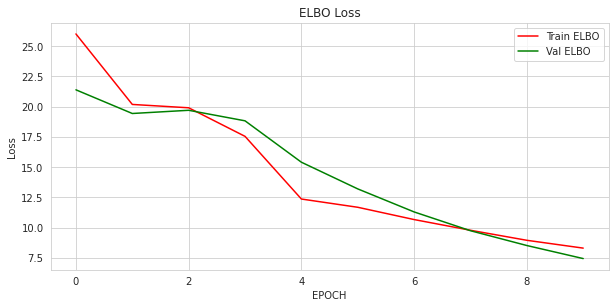

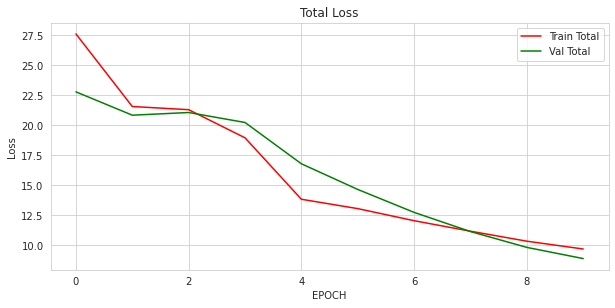

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['val_elbo']))), history_elbo['val_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')
plt.show();

plt.figure(figsize=(10,10))
plt.subplot(212)
plt.plot(list(range(0,len(history_total['train_total']))), history_total['train_total'], 'r')
plt.plot(list(range(0,len(history_total['val_total']))), history_total['val_total'],'g')
plt.legend(['Train Total','Val Total'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('Total Loss')

plt.show();

In [22]:
def predict(model, dataset):
  predictions, elbo_losses, total_losses = [], [],[]
  with torch.no_grad():
    model = model.eval()
    for x in dataset:
        x = x.to(device)
        
        outputs = model(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        mu_bar, log_var_bar = outputs["mu"], outputs["log_var"]
        z, z_bar = outputs["z"], outputs["z_bar"]

        loss, elbo = loss_function(x_hat, x, z, mu, log_var,z_bar,mu_bar,log_var_bar)

        elbo_losses.append(elbo.item())
        total_losses.append(loss.item())
        predictions.append(x_hat.cpu().numpy().flatten())
  return predictions,total_losses,elbo_losses

In [23]:
predict_train,total_losses_train,elbo_losses = predict(model, train_dataset)

#sns.distplot(total_losses, bins=20, kde=True);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


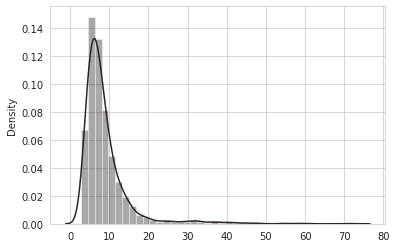

In [24]:
sns.distplot(total_losses_train, bins=40, kde=True);

In [31]:
THRESHOLD = 25

# Test with test data set

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


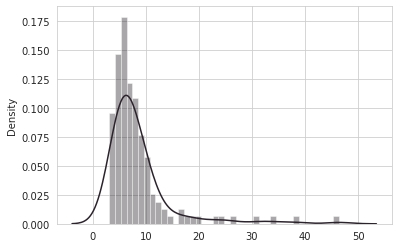

In [26]:
predict_test, total_losses_test, elbo_losses_test = predict(model,test_normal_dataset)

sns.distplot(total_losses_test, bins=40, kde=True);

Count the number of samples in between threshold 

In [32]:
correct = sum(l <= THRESHOLD for l in total_losses_test)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 140/145


In [28]:
def plot_prediction(data, model, title, ax):
  predictions, total_losses,elbo_losses = predict(model, [data])

  ax.plot(data,'r', label='true')
  ax.plot(predictions[0], 'b',label='reconstructed')
  ax.set_title(f'{title} (Total loss: {np.around(total_losses[0], 2)})')
  ax.legend()

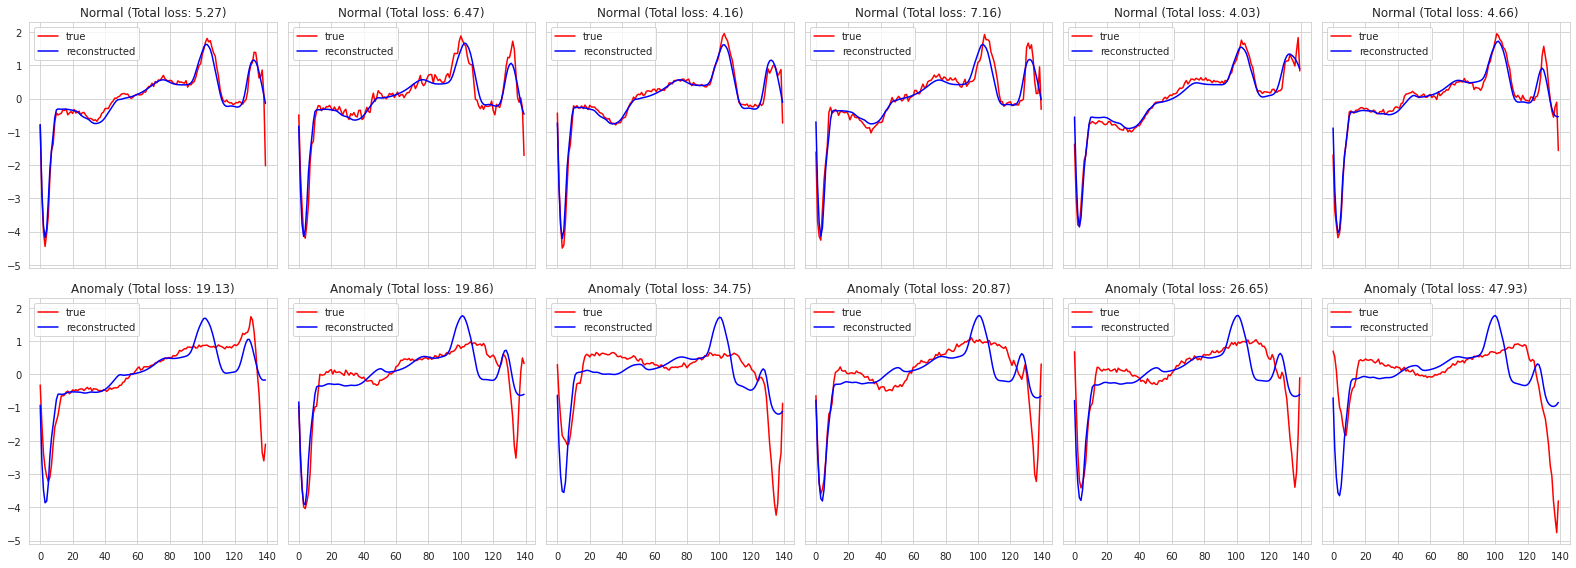

In [29]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [30]:
predict_test, total_losses_anomaly, elbo_losses_anomaly = predict(model,test_anomaly_dataset)
correct = sum(l > THRESHOLD for l in total_losses_anomaly)
print(f'Correct anomaly predictions: {correct}/{len(total_losses_anomaly)}')

Correct anomaly predictions: 2067/2081


In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, confusion_matrix

In [34]:
label = np.concatenate((np.ones(len(total_losses_test)),np.zeros(len(total_losses_test))))
total_losses = np.concatenate((total_losses_test,np.random.choice(total_losses_anomaly, len(total_losses_test),replace=True)),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_losses,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(5)

,Reconstruction_error,Label
0,4.655853,1.0
1,7.570701,1.0
2,3.472123,1.0
3,7.328362,1.0
4,3.842729,1.0
5,4.830063,1.0
6,13.873837,1.0
7,4.974220,1.0
8,10.088347,1.0
9,6.197006,1.0


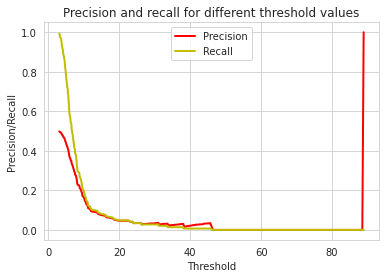

In [35]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.Label, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:],'r', label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:],'y', label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [36]:
threshold_fixed = 20

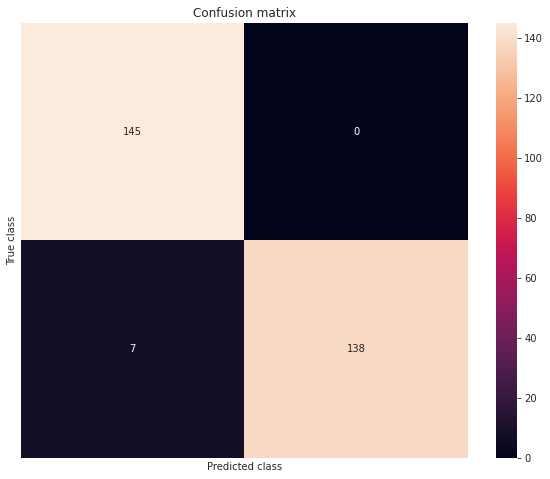

In [37]:
pred_y = [0 if e > threshold_fixed else 1 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.Label, pred_y)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=[], yticklabels=[], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

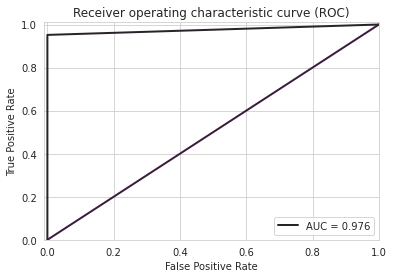

In [39]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Label, pred_y)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()